<a href="https://colab.research.google.com/github/rajghorui21/Environmental-Monitoring-Pollution-Control/blob/main/Environmental_Monitoring_and_Pollution_Control_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [208]:
import os
import time
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [209]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import joblib
plt.style.use('default')


In [210]:
path = '/content/air_quality_dataset.csv'
df = pd.read_csv(path)
df

,SITE_ID,Week,Year,DATEOFF,Ca,Cl,HNO3,HNO3 PPB,K,Mg,Na,NH4,NO3,SO2,SO2 PPB,SO4,TNO3,DATEON
0,ABT147,27,2023,7/11/2023 8:00:00 AM,0.042,0.032,0.759,0.295,0.129,0.022,0.055,0.279,0.088,0.258,0.098,0.915,0.834,7/04/2023
1,ABT147,28,2023,7/18/2023 8:00:00 AM,0.114,0.033,0.74,0.287,0.091,0.056,0.302,0.268,0.332,0.316,0.121,1.273,1.06,7/11/2023
2,ABT147,29,2023,7/25/2023 8:00:00 AM,0.062,0.033,0.648,0.251,0.074,0.02,0.07,0.276,0.128,0.294,0.112,0.705,0.766,7/18/2023
3,ABT147,30,2023,8/01/2023 8:00:00 AM,0.064,0.033,0.598,0.232,0.069,0.022,0.096,0.304,0.196,0.333,0.127,0.841,0.784,7/25/2023
4,ABT147,31,2023,8/08/2023 8:00:00 AM,0.059,0.176,0.348,0.135,0.065,0.033,0.208,0.366,0.382,0.331,0.126,0.596,0.724,8/01/2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2098,YOS404,48,2023,12/05/2023 8:00:00 AM,0.041,0.015,0.406,0.158,0.018,0.008,0.037,0.064,0.091,-,-,0.231,0.491,11/28/2023
2099,YOS404,49,2023,12/12/2023 8:00:00 AM,0.018,0.015,0.182,0.071,0.011,0.004,0.02,0.058,0.055,-,-,0.15,0.234,12/05/2023
2100,YOS404,50,2023,12/19/2023 8:00:00 AM,0.014,0.015,0.128,0.05,0.009,0.002,0.006,0.039,0.027,-,-,0.1,0.152,12/12/2023
2101,YOS404,51,2023,12/26/2023 8:00:00 AM,0.038,0.013,0.14,0.054,0.021,0.005,0.013,0.054,0.056,-,-,0.147,0.194,12/19/2023


In [211]:
def quick_overview(df, n=5):
    print("Shape:", df.shape)
    display(df.head(n))
    print("\nInfo:")
    print(df.info())
    print("\nDescribe (numeric):")
    display(df.describe().T)

if 'df' not in globals():
    rng = pd.date_range('2023-01-01', periods=100, freq='H')
    df = pd.DataFrame({
        'timestamp': rng,
        'pm2_5': np.abs(np.random.normal(50, 20, size=len(rng))),
        'pm10': np.abs(np.random.normal(80, 30, size=len(rng))),
        'no2': np.abs(np.random.normal(40, 15, size=len(rng))),
        'so2': np.abs(np.random.normal(10, 5, size=len(rng))),
        'co': np.abs(np.random.normal(0.7, 0.3, size=len(rng))),
        'temperature': np.random.normal(25, 5, size=len(rng)),
        'humidity': np.random.uniform(30, 80, size=len(rng))
    })
    print("Using simulated example dataframe (replace with your real data).")

quick_overview(df)

if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp').reset_index(drop=True)

Shape: (2103, 18)


,SITE_ID,Week,Year,DATEOFF,Ca,Cl,HNO3,HNO3 PPB,K,Mg,Na,NH4,NO3,SO2,SO2 PPB,SO4,TNO3,DATEON
0,ABT147,27,2023,7/11/2023 8:00:00 AM,0.042,0.032,0.759,0.295,0.129,0.022,0.055,0.279,0.088,0.258,0.098,0.915,0.834,7/04/2023
1,ABT147,28,2023,7/18/2023 8:00:00 AM,0.114,0.033,0.74,0.287,0.091,0.056,0.302,0.268,0.332,0.316,0.121,1.273,1.06,7/11/2023
2,ABT147,29,2023,7/25/2023 8:00:00 AM,0.062,0.033,0.648,0.251,0.074,0.02,0.07,0.276,0.128,0.294,0.112,0.705,0.766,7/18/2023
3,ABT147,30,2023,8/01/2023 8:00:00 AM,0.064,0.033,0.598,0.232,0.069,0.022,0.096,0.304,0.196,0.333,0.127,0.841,0.784,7/25/2023
4,ABT147,31,2023,8/08/2023 8:00:00 AM,0.059,0.176,0.348,0.135,0.065,0.033,0.208,0.366,0.382,0.331,0.126,0.596,0.724,8/01/2023



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2103 entries, 0 to 2102
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   SITE_ID   2103 non-null   object
 1   Week      2103 non-null   int64 
 2   Year      2103 non-null   int64 
 3   DATEOFF   2103 non-null   object
 4   Ca        2103 non-null   object
 5   Cl        2103 non-null   object
 6   HNO3      2103 non-null   object
 7   HNO3 PPB  2103 non-null   object
 8   K         2103 non-null   object
 9   Mg        2103 non-null   object
 10  Na        2103 non-null   object
 11  NH4       2103 non-null   object
 12  NO3       2103 non-null   object
 13  SO2       2103 non-null   object
 14  SO2 PPB   2103 non-null   object
 15  SO4       2103 non-null   object
 16  TNO3      2103 non-null   object
 17  DATEON    2103 non-null   object
dtypes: int64(2), object(16)
memory usage: 295.9+ KB
None

Describe (numeric):


,count,mean,std,min,25%,50%,75%,max
Week,2103.0,39.45126,7.510182,27.0,33.0,39.0,46.0,52.0
Year,2103.0,2023.00000,0.000000,2023.0,2023.0,2023.0,2023.0,2023.0


In [212]:
def missing_summary(df):
    miss = df.isnull().sum()
    pct = (miss / len(df) * 100).round(2)
    summary = pd.DataFrame({'missing_count': miss, 'missing_pct': pct})
    return summary[summary['missing_count']>0]

display(missing_summary(df))

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
imputer = SimpleImputer(strategy='median')
df[num_cols] = imputer.fit_transform(df[num_cols])

print("After imputation, missing summary (should be 0):")
display(missing_summary(df))


,missing_count,missing_pct


After imputation, missing summary (should be 0):


,missing_count,missing_pct


In [213]:
if 'DATEOFF' in df.columns:
    df['DATEOFF'] = pd.to_datetime(df['DATEOFF'])
    df = df.sort_values('DATEOFF').reset_index(drop=True)
    df['hour'] = df['DATEOFF'].dt.hour
    df['dayofweek'] = df['DATEOFF'].dt.dayofweek
    df['month'] = df['DATEOFF'].dt.month

display(df.head())

,SITE_ID,Week,Year,DATEOFF,Ca,Cl,HNO3,HNO3 PPB,K,Mg,...,NH4,NO3,SO2,SO2 PPB,SO4,TNO3,DATEON,hour,dayofweek,month
0,ABT147,27.0,2023.0,2023-07-11 08:00:00,0.042,0.032,0.759,0.295,0.129,0.022,...,0.279,0.088,0.258,0.098,0.915,0.834,7/04/2023,8,1,7
1,GRC474,27.0,2023.0,2023-07-11 08:00:00,0.32,0.06,0.719,0.279,0.128,0.045,...,0.261,0.354,0.206,0.079,0.81,1.061,7/04/2023,8,1,7
2,GRS420,27.0,2023.0,2023-07-11 08:00:00,0.104,0.014,0.675,0.262,0.067,0.018,...,0.277,0.035,0.131,0.05,0.953,0.699,7/04/2023,8,1,7
3,GTH161,27.0,2023.0,2023-07-11 08:00:00,0.19,0.018,0.227,0.088,0.045,0.028,...,0.171,0.149,0.124,0.047,0.416,0.372,7/04/2023,8,1,7
4,HOX148,27.0,2023.0,2023-07-11 08:00:00,0.231,0.033,0.649,0.252,0.149,0.065,...,0.285,0.202,0.243,0.093,0.704,0.841,7/04/2023,8,1,7


In [214]:
num_for_corr = ['Ca', 'Cl', 'HNO3', 'HNO3 PPB', 'K', 'Mg', 'Na', 'NH4', 'NO3', 'SO2', 'SO2 PPB', 'SO4', 'TNO3']
present = [c for c in num_for_corr if c in df.columns]

if len(present) >= 2:
    df_numeric = df[present].copy()
    for col in present:
        df_numeric[col] = df_numeric[col].replace('-', np.nan)
        df_numeric[col] = pd.to_numeric(df_numeric[col], errors='coerce')

    display(df_numeric.corr().round(2))

,Ca,Cl,HNO3,HNO3 PPB,K,Mg,Na,NH4,NO3,SO2,SO2 PPB,SO4,TNO3
Ca,1.00,0.04,0.26,0.26,0.38,0.39,0.04,0.15,0.29,0.15,0.15,0.29,0.37
Cl,0.04,1.00,-0.14,-0.14,0.44,0.84,0.98,-0.06,0.17,0.27,0.27,0.33,0.08
HNO3,0.26,-0.14,1.00,1.00,0.38,0.06,-0.10,0.37,0.07,0.20,0.20,0.47,0.54
HNO3 PPB,0.26,-0.14,1.00,1.00,0.38,0.06,-0.10,0.37,0.07,0.20,0.20,0.47,0.54
K,0.38,0.44,0.38,0.38,1.00,0.61,0.48,0.34,0.23,0.28,0.28,0.68,0.38
Mg,0.39,0.84,0.06,0.06,0.61,1.00,0.85,0.07,0.34,0.33,0.33,0.48,0.31
Na,0.04,0.98,-0.10,-0.10,0.48,0.85,1.00,-0.07,0.22,0.29,0.29,0.40,0.14
NH4,0.15,-0.06,0.37,0.37,0.34,0.07,-0.07,1.00,0.64,0.31,0.31,0.57,0.72
NO3,0.29,0.17,0.07,0.07,0.23,0.34,0.22,0.64,1.00,0.36,0.36,0.26,0.88
SO2,0.15,0.27,0.20,0.20,0.28,0.33,0.29,0.31,0.36,1.00,1.00,0.33,0.41


In [215]:
target = 'Mg'
features = [c for c in df.columns if c not in ['DATEOFF', 'DATEON', 'SITE_ID', target]]

for col in features:
    df[col] = df[col].replace('-', np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')


features = [c for c in features if df[c].dtype in [np.number]]

for t in ['hour','dayofweek','month']:
    if t in df.columns and t not in features:
        features.append(t)

print("Features used:", features)

X_temp = df[features].copy()
y_temp = df[target].copy()

y_temp = pd.to_numeric(y_temp, errors='coerce')

nan_rows = y_temp.isna()
X = X_temp[~nan_rows]
y = y_temp[~nan_rows]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_s, y_train)

preds = rf.predict(X_test_s)

print("MAE:", round(mean_absolute_error(y_test, preds), 3))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, preds)), 3))
print("R2:", round(r2_score(y_test, preds), 3))

joblib.dump(rf, 'rf_pm25_model.joblib')
joblib.dump(scaler, 'scaler_pm25.joblib')
print("Saved rf_pm25_model.joblib and scaler_pm25.joblib")

Features used: ['Week', 'Year', 'Ca', 'Cl', 'HNO3', 'HNO3 PPB', 'K', 'Na', 'NH4', 'NO3', 'SO2', 'SO2 PPB', 'SO4', 'TNO3', 'hour', 'dayofweek', 'month']


/tmp/ipython-input-2994617740.py:9: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  features = [c for c in features if df[c].dtype in [np.number]]


MAE: 0.01
RMSE: 0.025
R2: 0.91
Saved rf_pm25_model.joblib and scaler_pm25.joblib


,0
Na,0.476081
Ca,0.196538
Cl,0.188044
K,0.037724
NO3,0.021355
TNO3,0.012452
SO2,0.010952
SO2 PPB,0.010862
SO4,0.010622
HNO3,0.009357


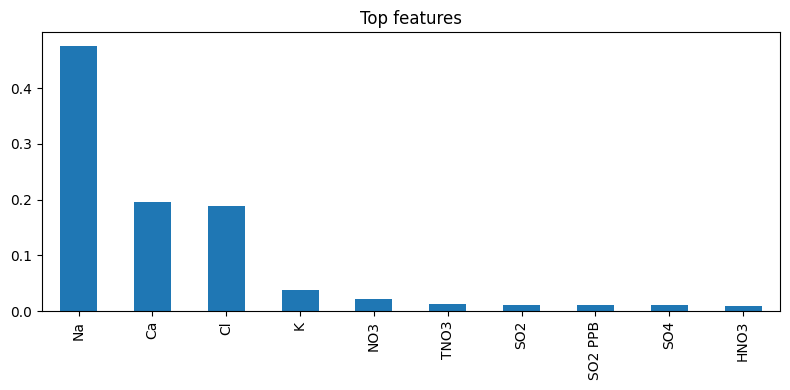

In [216]:
try:
    importances = rf.feature_importances_
    feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
    display(feat_imp.head(15))
    fig = feat_imp.head(10).plot(kind='bar', figsize=(8,4), title='Top features')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Could not compute feature importance:", e)


In [217]:
THRESH_Mg = 0.1

latest = df.iloc[-1]
latest_mg = float(latest['Mg'])
print(f"Latest timestamp: {latest['DATEOFF']}, Mg = {latest_mg}")

if latest_mg >= THRESH_Mg:
    print("ALERT: Mg above threshold! Take action.")
else:
    print("Air Quality normal.")

Latest timestamp: 2024-01-02 08:00:00, Mg = 0.004
Air Quality normal.


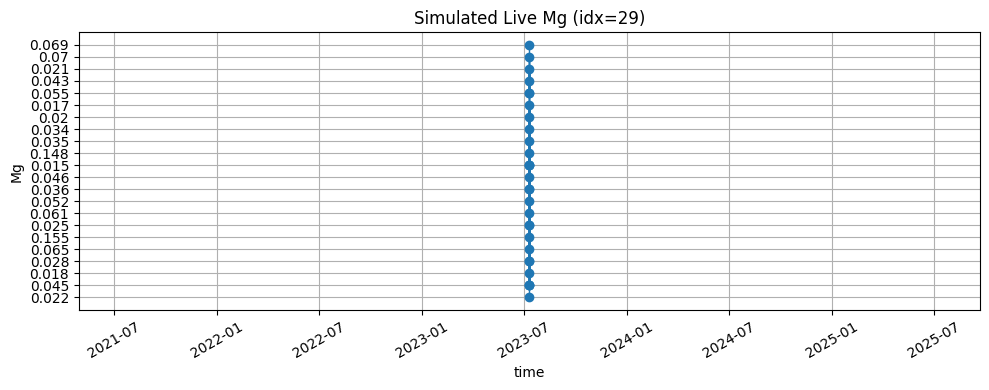

Define simulate_live_plot(...) and uncomment the call to run the simulation.


In [218]:
from IPython.display import clear_output, display

def simulate_live_plot(df, n_points=50, pause=0.5):

    window = []
    timestamps = []
    for idx, row in df.iterrows():
        window.append(row['Mg'])
        timestamps.append(row['DATEOFF'] if 'DATEOFF' in df.columns else idx)
        if len(window) > n_points:
            window.pop(0)
            timestamps.pop(0)
        clear_output(wait=True)
        plt.figure(figsize=(10,4))
        plt.plot(timestamps, window, marker='o', linewidth=1)
        plt.title(f"Simulated Live Mg (idx={idx})")
        plt.xlabel('time')
        plt.ylabel('Mg')
        plt.xticks(rotation=30)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        time.sleep(pause)


simulate_live_plot(df.head(30), n_points=50, pause=0.5)
print("Define simulate_live_plot(...) and uncomment the call to run the simulation.")